In [0]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [0]:
# Loading Datasets on to DataFrames
indicators_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/2018_all_indicators.csv'
education_url = 'https://github.com/chc5/education-indicator-analysis/raw/master/adult_education_level.csv'

inds_df = pd.read_csv(indicators_url)
ed_df = pd.read_csv(education_url)

# Column 9999 in the Indicators Dataset only shows the latest value from the data drawn within 1990 to 2017.
# In order to detect education system growth predictors this column is unneccessary.
inds_df = inds_df.drop(columns=['9999'])

In [0]:
# Many indicators from 1990 to 2017 that only have at most one or two recordings for a specific indicators.
# These recordings may or may not indicate growth over the years which will not contribute to our analysis.
# These indicators will be dropped.
# When threshold = 1, it removed 25636 - 20588 = 5048 / 25636 = 20% of the indicators
threshold = 10
drop_stack = set()
print("Number of rows in the indicators data frame before:", len(inds_df))
for index, row in inds_df.iterrows():
#     print(row['1990':].count())
    if row['1990':].count() <= threshold:
        drop_stack.add(index)
inds_df = inds_df.drop(drop_stack)
print("Number of rows in the indicators data frame after:", len(inds_df))


Number of rows in the indicators data frame before: 25636
Number of rows in the indicators data frame after: 13968


In [0]:
# Get the missing values at each year and return the array of years (aka. column)
def get_missing_yearly_values(row):
    row_df = row.to_frame().reset_index()
    row_df = row_df.drop(range(5))
    row_df.columns = ['x', 'y']
    missing_X = row_df[row_df['y'].isnull()].x
    return missing_X

# Predicting the missing values using Linear Regression Models
# and then filling out the missing values based on the model
year_columns = inds_df.columns.values[5:]
for index, row in inds_df.iterrows():
    missing_years = get_missing_yearly_values(row).values
    # If there are nothing to fill out then we don't need to model it out.
    if missing_years.size <= 0:
        continue
    row = row.drop(missing_years)
    row = row.drop(['dimension', 'indicator_id', 'indicator_name', 'iso3', 'country_name'])
    value = row.values.reshape(-1, 1)
    year = year_columns
    # The difference set of total years and missing years are the years where there are recorded values.
    year = np.setdiff1d(year, missing_years).astype(int).reshape(-1, 1)
    missing_years = missing_years.astype(int)
    missing_years = missing_years.reshape(missing_years.shape[0],-1)
    
    reg = LinearRegression()
    reg.fit(year, value)
    missing_values = reg.predict(missing_years)
    # Filling out the missing data
    for i in range(len(missing_years)):
        inds_df.at[index, str(missing_years[i][0])] = missing_values[i][0]
        

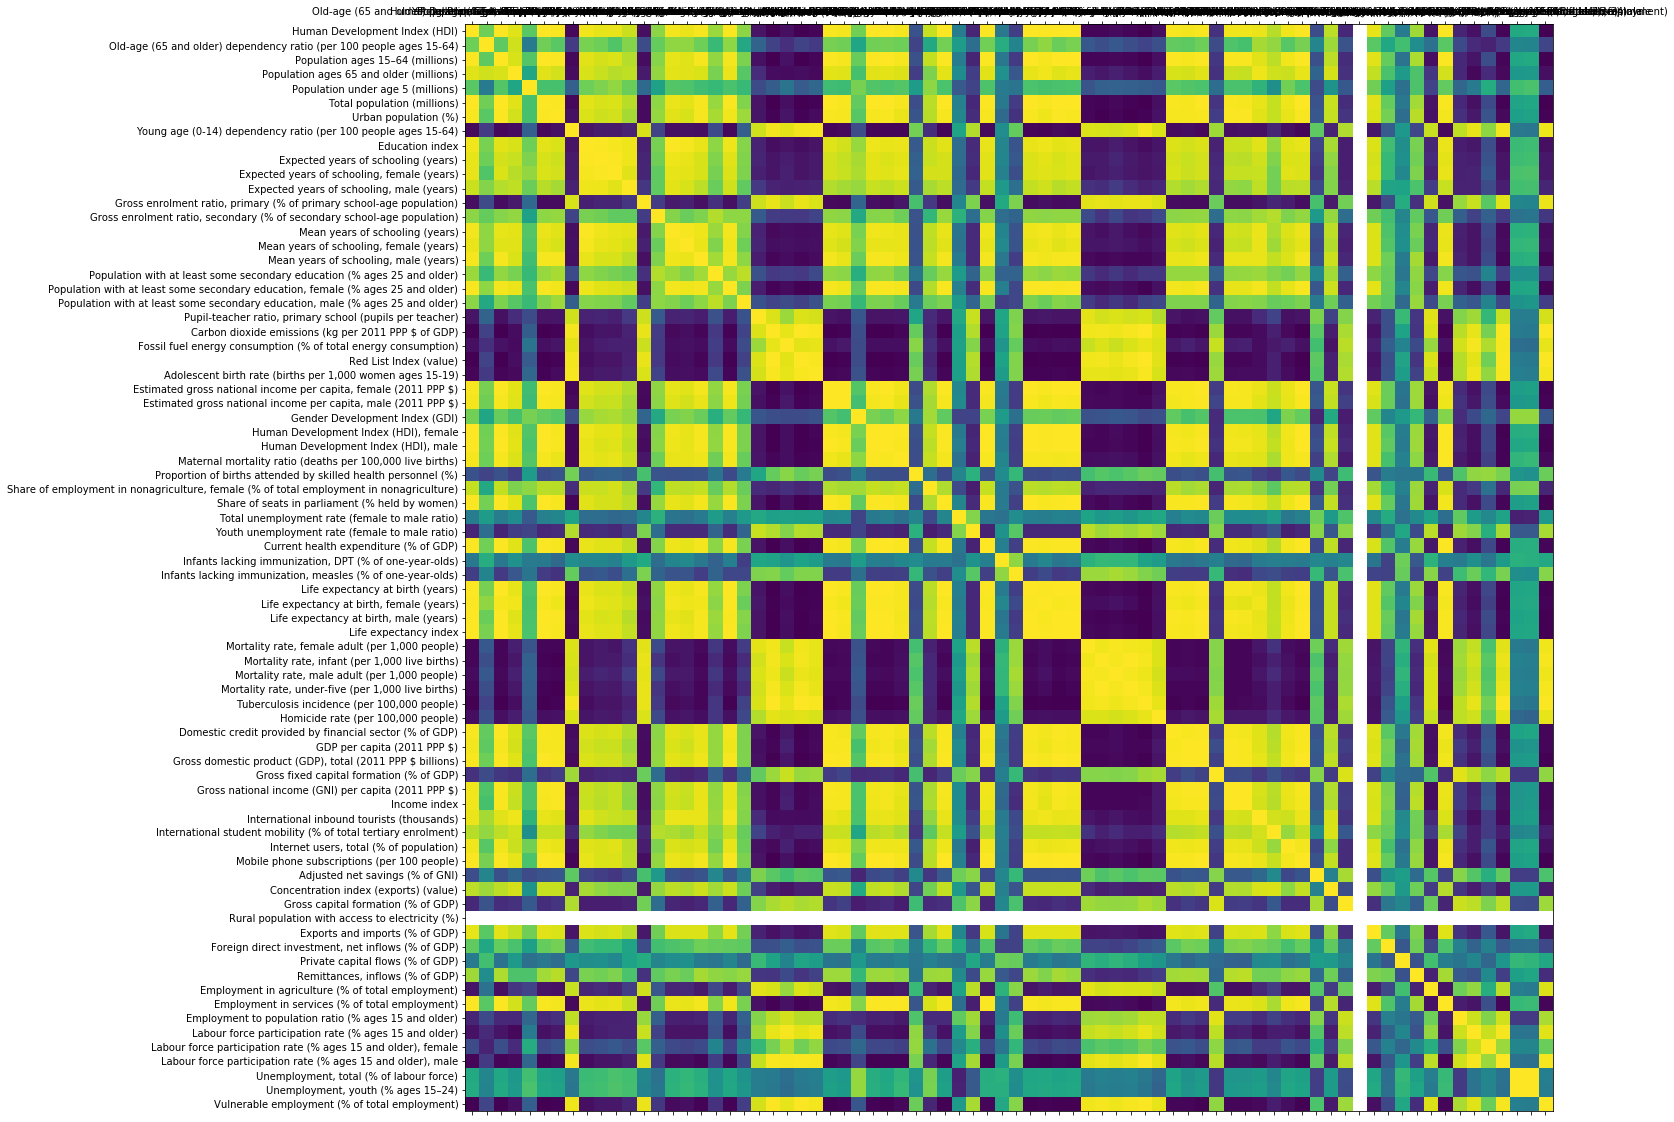

In [0]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
country_names = inds_df.country_name.unique()
  
def plot_corr_country(df, country):
  # drop ids etc., get only rows with country, transpose
  df_corr = inds_df.drop(df.columns[[0, 1, 3]], axis=1)[df.country_name == country].T
  # fix columns
  df_corr.columns = df_corr.iloc[0]
  # drop first two rops
  df_corr = df_corr[2:]
  # df_corr = inds_df.drop(inds_df.columns[[0, 1, 3]], axis=1).drop(inds_df.columns[range(5,32)], axis=1)[inds_df.country_name == "Albania"]
  df_corr = df_corr.apply(pd.to_numeric)
  plot_corr(df_corr, size=20)
  return df_corr

# change threshold to get more columns 
df_corr = plot_corr_country(inds_df, "United States")

In [0]:
# Education Index: A standard created by United Nations that determines educational attainment in countries
# The formula for Education Index = MYSI + EYSI / 2
# Mean Years of Schooling Index : MYS / 15
# Mean Years of Schooling : Average number of years of education received by people ages 25 and older
# Expected Years of Schooling Index: EYS / 18
# Expected Years of Schooling : The number of years a child is expected to attend school, or university, including the years spent on repetition.
# Source : https://en.wikipedia.org/wiki/Education_Index

# Get the strongest indicators towards the Education Index by getting the strongest correlation of determination (R^2)
# between every other indicators to the Education Index. 
def get_strongest_correlations(df_corr, indicator, num_indicators = 10):
    correlations = []
    for row in df_corr.corr():
        corr_determ = df_corr.corr()[row][indicator] ** 2
        correlations.append([row, corr_determ])
    
    correlations.sort(key = lambda corr: corr[1], reverse=True)
    return correlations[:num_indicators]

potential_indicators = get_strongest_correlations(df_corr, 'Education index', 20)

# Dropping 'Education index', 'Expected years of schooling (years)', 'Mean years of schooling (years)' and others because they are part of the formula
dependent_ind = ['Education index', 
                 'Expected years of schooling (years)', 
                 'Mean years of schooling (years)', 
                 'Expected years of schooling, female (years)',
                 'Mean years of schooling, female (years)',
                 'Expected years of schooling, male (years)',
                 'Expected years of schooling, male (years)',
                 'Mean years of schooling, male (years)'
                ]
potential_indicators = [p for p in potential_indicators if p[0] not in dependent_ind]
print(potential_indicators)

def check_corr(df_corr, potential_indicators, target_feature):
    features_ex = [indicator[0] for indicator in potential_indicators]
    features_ex.remove(target_feature)
    for feature in features_ex:
        if df_corr.corr()[target_feature][feature] > 0.95:
            print(target_feature, feature)
            return False
    return True

potential_ret_val = []
for indicator_pair in potential_indicators:
    potential_ret_val.append(check_corr(df_corr, potential_indicators, indicator_pair[0]))
print(potential_ret_val)

#def check_independence(potential_indicators):
    
    
        

[['Human Development Index (HDI)', 0.9155694465151759], ['Life expectancy at birth, female (years)', 0.899078181614719], ['Population with at least some secondary education, female (% ages 25 and older)', 0.8974672986657369], ['Human Development Index (HDI), female', 0.8962859073054256], ['Maternal mortality ratio (deaths per 100,000 live births)', 0.882614104111885], ['Current health expenditure (% of GDP)', 0.8781048635986949], ['Human Development Index (HDI), male', 0.8704313318006444], ['Red List Index (value)', 0.8593401555649407], ['Carbon dioxide emissions (kg per 2011 PPP $ of GDP)', 0.8552097229867266], ['Total population (millions)', 0.8448012772824336], ['Share of seats in parliament (% held by women)', 0.8294802251264682], ['Population ages 15–64 (millions)', 0.8276432176448972], ['Estimated gross national income per capita, female (2011 PPP $)', 0.8132443932435461]]
Human Development Index (HDI) Life expectancy at birth, female (years)
Life expectancy at birth, female (yea

In [0]:
df_corr.corr()

In [0]:
df_corr.corr().info()

In [0]:
#df_corr.corr()['Old-age (65 and older) dependency ratio (per 100 people ages 15-64)']['Human Development Index (HDI)']
df_corr.corr()['Old-age (65 and older) dependency ratio (per 100 people ages 15-64)']

In [0]:
df_corr.corr().keys()

In [0]:
len(df_corr.corr())

In [0]:
df_corr.corr()['Human Development Index (HDI)']['Education index']

In [0]:
potential_indicators